In [44]:
!pip install pandas
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [45]:
import simpy
import random
import numpy as np

## **Ejercicio 2**

In [46]:
class Servidor:
    def __init__(self, env, id_servidor):
        self.env = env
        self.id_servidor = id_servidor
        self.procesador = simpy.Resource(env, capacity=1)
        self.carga = 0

    def procesar(self, solicitud):
        # el tiempo de procesamiento del servidor sigue una distribución exponencial
        tiempo_procesamiento = random.expovariate(1 / TIEMPO_PROCESAMIENTO_PROM)
        self.carga += 1
        yield self.env.timeout(tiempo_procesamiento)
        tiempos_atencion_servidores.append(tiempo_procesamiento)
        self.carga -= 1

In [47]:
class BalanceadorRoundRobin:
    def __init__(self, env, servidores):
        if env is not None:
            self.env = env
            self.procesador = simpy.Resource(env, capacity=1)
        self.servidores = servidores
        self.ultimo_servidor = 0

    def balancear(self, solicitud):
        servidor = None
        with self.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_balanceador.append(self.env.now- tiempo_inicio_espera)
            yield self.env.timeout(TIEMPO_BALANCEADOR)
            servidor = self.seleccionar_servidor()
        
        with servidor.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_servidores.append(self.env.now - tiempo_inicio_espera)
            yield self.env.process(servidor.procesar(solicitud))

    def seleccionar_servidor(self):
        servidor = self.servidores[self.ultimo_servidor]
        self.ultimo_servidor = (self.ultimo_servidor + 1) % len(self.servidores)
        return servidor


In [48]:
class BalanceadorDifuso:
    def __init__(self, env, servidores, grafo, umbral):
        self.env = env
        self.servidores = servidores
        self.balanceador_round_robin = BalanceadorRoundRobin(None, servidores)
        self.procesador = simpy.Resource(env, capacity=1)
        self.grafo = grafo
        self.umbral = umbral

    def balancear(self, solicitud):
        servidor = None
        with self.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_balanceador.append(self.env.now - tiempo_inicio_espera)
            yield self.env.timeout(TIEMPO_BALANCEADOR)
            servidor = self.seleccionar_servidor()

        with servidor.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_servidores.append(self.env.now - tiempo_inicio_espera)
            yield self.env.process(servidor.procesar(solicitud))

    def seleccionar_servidor(self):
        # selecciona un servidor con menor carga siguiendo el grafo y el umbral de carga
        servidor_inicial = self.balanceador_round_robin.seleccionar_servidor() # round robin como dice en el paper
        return self.propagacion_difusa(servidor_inicial)

    def propagacion_difusa(self, servidor_actual):
        # busca el servidor menos cargado entre los vecinos si la diferencia de carga excede el umbral
        visitados = set()  # para evitar ciclos en el grafo
        cola = [servidor_actual]

        while cola:
            servidor = cola.pop(0)
            visitados.add(servidor.id_servidor)

            vecinos = [self.servidores[vid] for vid in self.grafo[servidor.id_servidor] if vid not in visitados]
            if not vecinos:
                break  # no hay vecinos a los que propagar

            servidor_menos_cargado = min(vecinos, key=lambda s: s.carga)
            diferencial_carga = servidor.carga - servidor_menos_cargado.carga

            if diferencial_carga > self.umbral:
                cola.append(servidor_menos_cargado)  # propaga al vecino menos cargado
            else:
                return servidor  # retorna el servidor actual si la carga es aceptable

        return servidor_actual  # devuelve el servidor inicial si no se encontró uno mejor

In [49]:
def generar_solicitudes(env, balanceador):
    solicitud_id = 0

    for _ in range(CANTIDAD_SOLICITUDES):
        env.process(balanceador.balancear(solicitud_id))
        solicitud_id += 1
        yield env.timeout(random.expovariate(TASA_SOLICITUDES))

In [50]:
def simular(tecnica, num_servidores):
    env = simpy.Environment()
    servidores = [Servidor(env, i) for i in range(num_servidores)]
    
    if tecnica == "Difuso":
        balanceador = BalanceadorDifuso(env, servidores, grafo, UMBRAL_PROPAGACION)
    elif tecnica == "Round Robin":
        balanceador = BalanceadorRoundRobin(env, servidores)
    else:
        raise ValueError("Técnica no soportada en esta simulación")

    env.process(generar_solicitudes(env, balanceador))
    env.run()

In [51]:
import pandas as pd

def armar_configuracion(df, configuracion, tecnica):
    configuracion = [configuracion] * 3
    tecnica = [tecnica] * 3
    media = df.mean().to_frame(name = "Media")
    mediana = df.median().to_frame(name = "Mediana")
    desvio_estandar = df.std().to_frame(name = "Desvío estándar")
    resultado = media.join(mediana).join(desvio_estandar)
    resultado["Configuracion"] = configuracion
    resultado["Técnica"] = tecnica
    resultado = resultado.reset_index().rename(columns = {"index": "Métrica"})
    return resultado

def concatenar_metricas(configuraciones):
    return pd.concat(configuraciones).reset_index().drop(columns = "index")

def definir_metricas():
    metricas = {"Espera cola balanceador": tiempos_espera_cola_balanceador,
                "Espera cola servidores": tiempos_espera_cola_servidores,
                "Procesamiento de las solicitudes": tiempos_atencion_servidores}
    return metricas

### **Parámetros comunes**

In [52]:
CANTIDAD_SOLICITUDES = 100_000
UMBRAL_PROPAGACION = 5 # Diferencia de carga para propagación en balanceador difuso

# Definición de la red de servidores en forma de grafo (lista de adyacencia)

### **Configuración 1**

In [53]:
# Parámetros de la simulación
TASA_SOLICITUDES = 10                # Tasa de llegada de solicitudes en solicitudes/segundo (poisson)
TIEMPO_BALANCEADOR = 0.1           # Tiempo que toma al balanceador derivar la solicitud en segundos
TIEMPO_PROCESAMIENTO_PROM = 1     # Tiempo promedio de procesamiento en segundos de los servidores

NUM_SERVIDORES = 5                # Número de servidores
grafo = {
    0: [1, 2],
    1: [3, 4],
    2: [3, 4],
    3: [0, 1],
    4: [0, 1]
}

#### Round Robin

In [54]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Round Robin", NUM_SERVIDORES)
metricas_rr = definir_metricas()
df_rr_1 = pd.DataFrame(metricas_rr)
config_rr_1 = armar_configuracion(df_rr_1, 1, "Round Robin")
df_rr_1["Configuracion"] = [1] * CANTIDAD_SOLICITUDES
config_rr_1

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,24.911143,23.205430,11.844806,1,Round Robin
1,Espera cola servidores,5013.129855,5043.565409,2905.938861,1,Round Robin
2,Procesamiento de las solicitudes,1.001917,0.693108,1.002833,1,Round Robin


#### Difuso

In [55]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Difuso", NUM_SERVIDORES)
metricas_d = definir_metricas()
df_d_1 = pd.DataFrame(metricas_d)
config_d_1 = armar_configuracion(df_d_1, 1, "Difuso")
df_d_1["Configuracion"] = [1] * CANTIDAD_SOLICITUDES
config_d_1

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,18.351714,19.160122,10.974925,1,Difuso
1,Espera cola servidores,4987.629407,4986.109909,2865.632313,1,Difuso
2,Procesamiento de las solicitudes,0.996999,0.689150,1.003390,1,Difuso


### **Configuración 2**

In [56]:
# Parámetros de la simulación
TASA_SOLICITUDES = 20                # Tasa de llegada de solicitudes en solicitudes/segundo (poisson)
TIEMPO_BALANCEADOR = 0.05           # Tiempo que toma al balanceador derivar la solicitud en segundos
TIEMPO_PROCESAMIENTO_PROM = 0.5     # Tiempo promedio de procesamiento en segundos de los servidores

NUM_SERVIDORES = 5                  # Número de servidores
grafo = {
    0: [1, 2],
    1: [3, 4],
    2: [3, 4],
    3: [0, 1],
    4: [0, 1]
}

#### Round Robin

In [57]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Round Robin", NUM_SERVIDORES)
metricas_rr = definir_metricas()
df_rr_2 = pd.DataFrame(metricas_rr)
config_rr_2 = armar_configuracion(df_rr_2, 2, "Round Robin")
df_rr_2["Configuracion"] = [2] * CANTIDAD_SOLICITUDES
config_rr_2

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,16.207831,18.078752,5.388798,2,Round Robin
1,Espera cola servidores,2469.741625,2460.998208,1435.229434,2,Round Robin
2,Procesamiento de las solicitudes,0.497523,0.343016,0.497366,2,Round Robin


#### Difuso

In [58]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Difuso", NUM_SERVIDORES)
metricas_d = definir_metricas()
df_d_2 = pd.DataFrame(metricas_d)
config_d_2 = armar_configuracion(df_d_2, 2, "Difuso")
df_d_2["Configuracion"] = [2] * CANTIDAD_SOLICITUDES
config_d_2

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,3.792060,3.510316,2.638542,2,Difuso
1,Espera cola servidores,2489.997550,2487.216461,1439.708045,2,Difuso
2,Procesamiento de las solicitudes,0.499419,0.345559,0.499926,2,Difuso


### **Configuracion 3**

In [59]:
# Parámetros de la simulación
TASA_SOLICITUDES = 40                # Tasa de llegada de solicitudes en solicitudes/segundo (poisson)
TIEMPO_BALANCEADOR = 0.025           # Tiempo que toma al balanceador derivar la solicitud en segundos
TIEMPO_PROCESAMIENTO_PROM = 0.25     # Tiempo promedio de procesamiento en segundos de los servidores

NUM_SERVIDORES = 5                  # Número de servidores
grafo = {
    0: [1, 2],
    1: [3, 4],
    2: [3, 4],
    3: [0, 1],
    4: [0, 1]
}

#### Round Robin

In [60]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Round Robin", NUM_SERVIDORES)
metricas_rr = definir_metricas()
df_rr_3 = pd.DataFrame(metricas_rr)
config_rr_3 = armar_configuracion(df_rr_3, 3, "Round Robin")
df_rr_3["Configuracion"] = [3] * CANTIDAD_SOLICITUDES
config_rr_3

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,3.205361,2.915420,2.230756,3,Round Robin
1,Espera cola servidores,1237.289116,1232.021276,718.822198,3,Round Robin
2,Procesamiento de las solicitudes,0.250034,0.173817,0.250097,3,Round Robin


#### Difuso

In [61]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Difuso", NUM_SERVIDORES)
metricas_d = definir_metricas()
df_d_3 = pd.DataFrame(metricas_d)
config_d_3 = armar_configuracion(df_d_3, 3, "Difuso")
df_d_3["Configuracion"] = [3] * CANTIDAD_SOLICITUDES
config_d_3

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,1.939457,1.955159,1.140669,3,Difuso
1,Espera cola servidores,1251.518481,1246.757037,727.580407,3,Difuso
2,Procesamiento de las solicitudes,0.250881,0.173342,0.251395,3,Difuso


### **Combinar Resultados**

In [62]:
resultados_rr = [config_rr_1, config_rr_2, config_rr_3]
distribuciones_rr = [df_rr_1, df_rr_2, df_rr_3]
resultados_d = [config_d_1, config_d_2, config_d_3]
distribuciones_d = [df_d_1, df_d_2, df_d_3]
combinaciones_dist = concatenar_metricas(distribuciones_rr + distribuciones_d)
combinacion_rr = concatenar_metricas(resultados_rr)
combinacion_d = concatenar_metricas(resultados_d)

In [63]:
metrica_1_rr = combinacion_rr.loc[combinacion_rr["Métrica"] == "Espera cola balanceador"]
metrica_1_d = combinacion_d.loc[combinacion_d["Métrica"] == "Espera cola balanceador"]
metrica_2_rr = combinacion_rr.loc[combinacion_rr["Métrica"] == "Procesamiento de las solicitudes"]
metrica_2_d = combinacion_d.loc[combinacion_d["Métrica"] == "Procesamiento de las solicitudes"]
metrica_3_rr = combinacion_rr.loc[combinacion_rr["Métrica"] == "Espera cola servidores"]
metrica_3_d = combinacion_d.loc[combinacion_d["Métrica"] == "Espera cola servidores"]

metrica_1 = pd.concat([metrica_1_rr, metrica_1_d])
metrica_2 = pd.concat([metrica_2_rr, metrica_2_d])
metrica_3 = pd.concat([metrica_3_rr, metrica_3_d])

### **Comparaciones de medidas**

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_compraracion(metrica, medida, data):
    fig, axes = plt.subplots(ncols = 1)
    sns.barplot(x = "Configuracion", y = metrica, data = data, 
                palette = "flare", hue = "Técnica")
    plt.title(f"Comparacion {metrica} {medida}")
    plt.show()

### **Media**

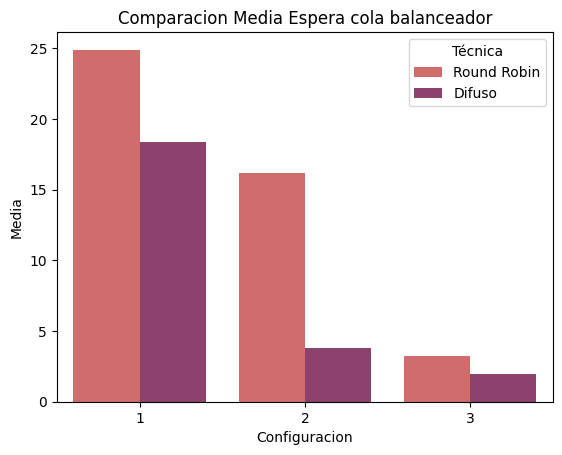

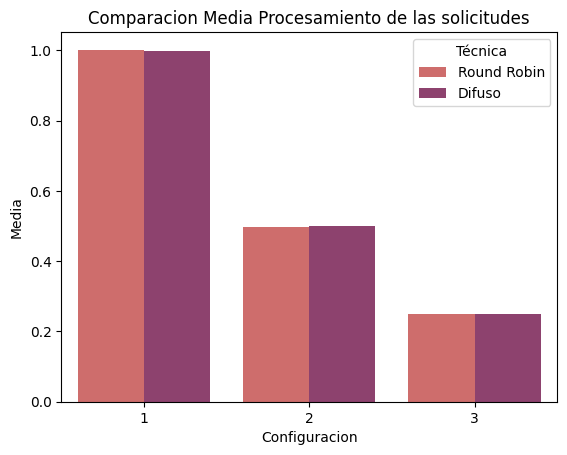

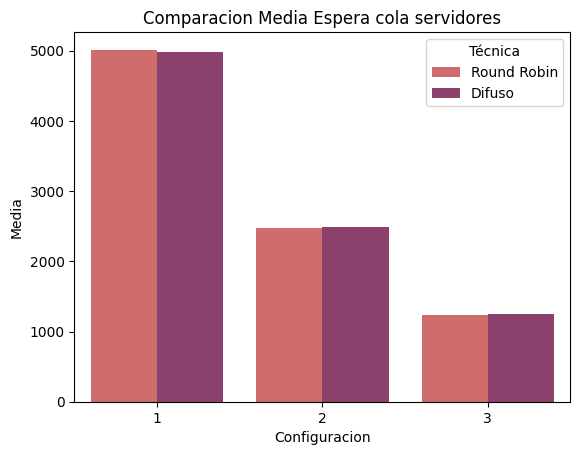

In [66]:
plot_compraracion("Media","Espera cola balanceador", metrica_1)
plot_compraracion("Media","Procesamiento de las solicitudes", metrica_2)
plot_compraracion("Media","Espera cola servidores", metrica_3)

### **Mediana**

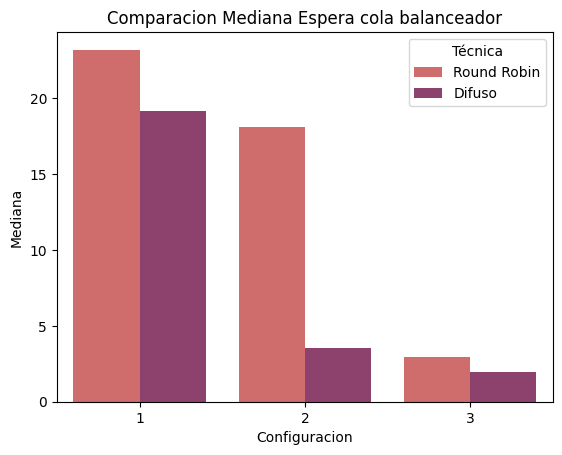

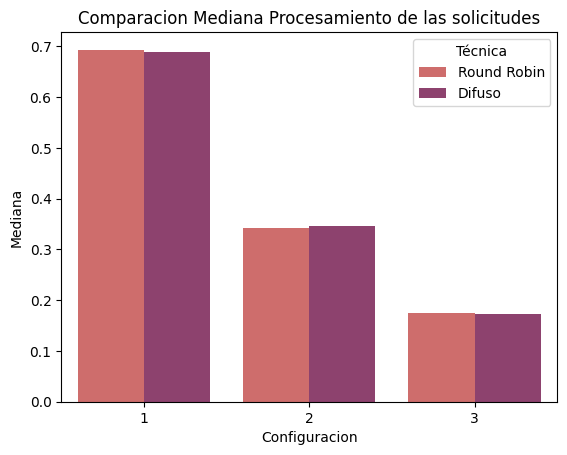

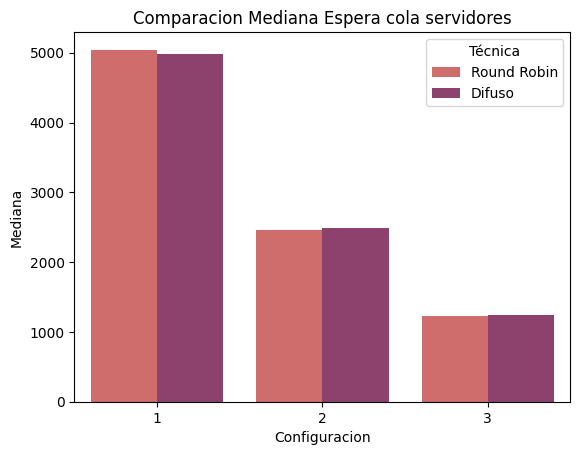

In [67]:
plot_compraracion("Mediana","Espera cola balanceador", metrica_1)
plot_compraracion("Mediana","Procesamiento de las solicitudes", metrica_2)
plot_compraracion("Mediana","Espera cola servidores", metrica_3)

### **Desvío Estándar**

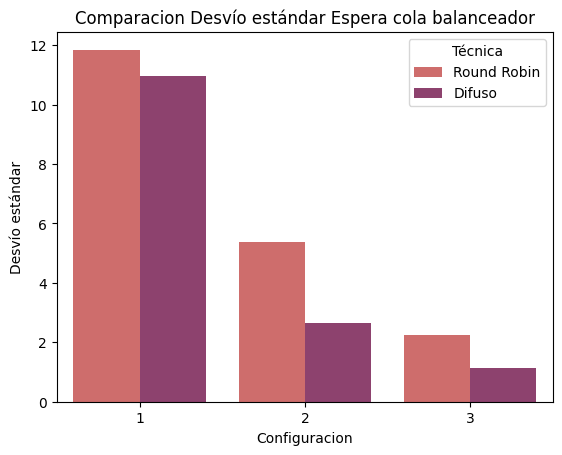

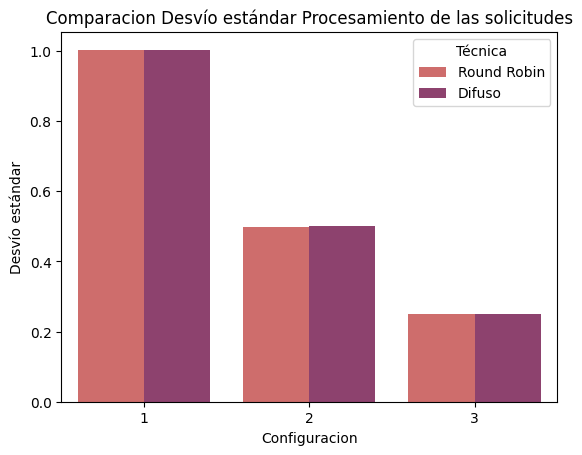

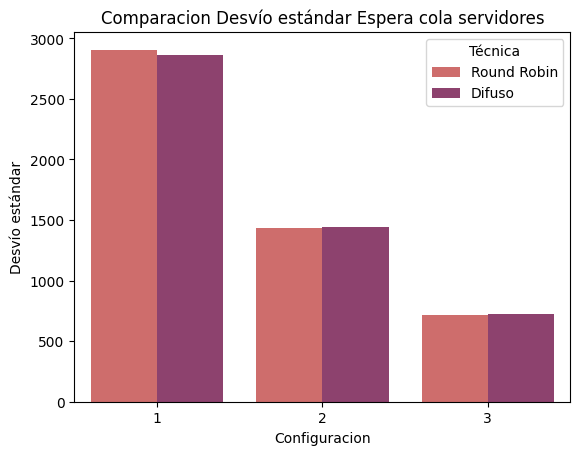

In [68]:
plot_compraracion("Desvío estándar","Espera cola balanceador", metrica_1)
plot_compraracion("Desvío estándar","Procesamiento de las solicitudes", metrica_2)
plot_compraracion("Desvío estándar","Espera cola servidores", metrica_3)

#### **Análisis de resultados**

Los gráficos de barra que se enseñan nos dan una referencia de como se comportan las distintas métricas 
(Los tiempos de espera tanto en cola como en servidores y el tiempo de procesamiento de las solicitudes)

En primer lugar cabe destacar las variaciones en los tiempos de espera en la cola. Se observa que a medida que aumenta la tasa de solicitudes bajando a la mitad los tiempos de procesamiento las medidas suelen ser más bajas utilizando la técnica del balanceador difuso que en el Round Robin.

Luego, en las demás métricas notamos que si bien varían entre configuraciones, la variación entre las distintas técnicas es la misma para las tres composiciones. 
En cuanto al tiempo de procesamiento en los servidores es lógico que ocurra, ya que dada la implementación los servidores son los mismos.
Con respecto al tiempo de espera en la cola de los servidores dado que las cargas son relativamente bajas por lo tanto no varían. Pero también nos dimos cuenta que si las aumentamos los tiempos en el difuso deberían ser menores, pero el cambio no resulto significativo.

### **Distribuciones**

In [70]:
combinaciones_dist_rr = concatenar_metricas(distribuciones_rr)
combinaciones_dist_d = concatenar_metricas(distribuciones_d)

def comparar_distribuciones(distribucion, df1, df2):
    fig, axes = plt.subplots(ncols = 2)
    sns.kdeplot(data = df1, x = distribucion, 
                hue = "Configuracion", palette = "flare", ax = axes[0])
    sns.kdeplot(data = df2, x = distribucion, 
                hue = "Configuracion", palette = "flare", ax = axes[1])
    plt.suptitle(distribucion)
    axes[1].set_ylabel("")
    axes[1].set_yticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Round Robin")
    axes[1].set_title("Difuso")
    plt.show()

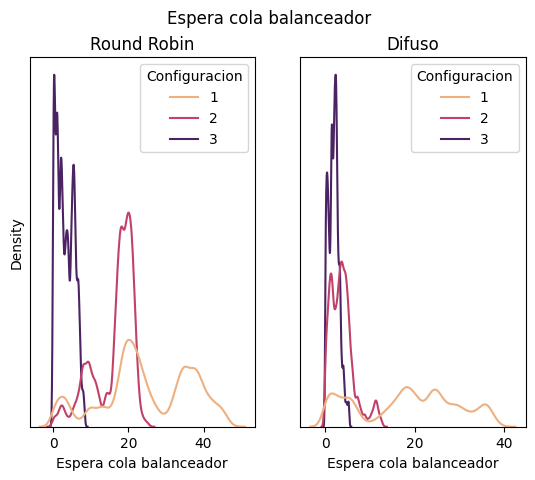

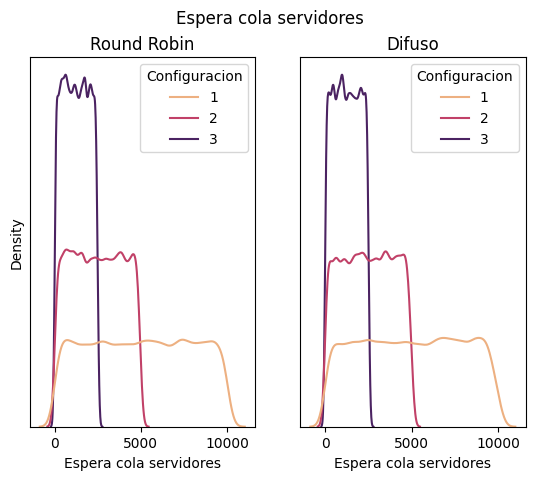

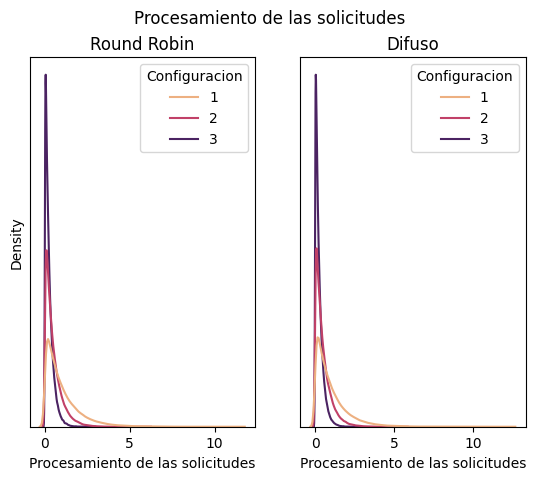

In [71]:
comparar_distribuciones("Espera cola balanceador", combinaciones_dist_rr, combinaciones_dist_d)
comparar_distribuciones("Espera cola servidores", combinaciones_dist_rr, combinaciones_dist_d)
comparar_distribuciones("Procesamiento de las solicitudes", combinaciones_dist_rr, combinaciones_dist_d)

### **Análisis de resultados**

En cuanto a las distribuciones observamos la tendencia que habíamos visto en el análisis anterior, la única variación se da en el tiempo de espera de la cola del balanceador en la misma linea del análisis de las medidas.